In [27]:
import pandas as pd
%matplotlib inline

from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
PoleWard_46320 = 'drive/My Drive/Projects/PlastOPol/Datasets/PoleWard_46320.csv'

In [60]:
data = pd.read_csv(PoleWard_46320)
data

,L,drifter_index,time,longitude,latitude,sea_surface_temperature
0,0,46320.0,2007-06-24 18:00:00,4.285,62.821,284.916
1,1,46320.0,2007-06-25 00:00:00,4.355,62.827,284.946
2,2,46320.0,2007-06-25 06:00:00,4.410,62.846,285.001
3,3,46320.0,2007-06-25 12:00:00,4.488,62.865,284.914
4,4,46320.0,2007-06-25 18:00:00,4.526,62.870,284.894
...,...,...,...,...,...,...
196,196,46320.0,2007-08-12 18:00:00,11.346,64.988,286.983
197,197,46320.0,2007-08-13 00:00:00,11.374,64.992,286.940
198,198,46320.0,2007-08-13 06:00:00,11.384,64.990,287.063
199,199,46320.0,2007-08-13 12:00:00,11.392,64.992,287.347


In [117]:
hourly_data = new_data.drop(['time', 'sea_surface_temperature'], axis=1)
hourly_data

,longitude,latitude
0,4.285,62.821
1,4.355,62.827
2,4.410,62.846
3,4.488,62.865
4,4.526,62.870
...,...,...
196,11.346,64.988
197,11.374,64.992
198,11.384,64.990
199,11.392,64.992


# Hourly Data Prediction

In [118]:
## try hourly data


# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 

NUM_TIME_STEPS_FORECASTS = 4
# load dataset
values = hourly_data.values
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 2*NUM_TIME_STEPS_FORECASTS)
# drop columns we don't want to predict
# reframed.drop(reframed.columns[[2,3]], axis=1, inplace=True)
reframed

,var1(t-1),var2(t-1),var1(t),var2(t),var1(t+1),var2(t+1),var1(t+2),var2(t+2),var1(t+3),var2(t+3),var1(t+4),var2(t+4),var1(t+5),var2(t+5),var1(t+6),var2(t+6),var1(t+7),var2(t+7)
1,0.000000,0.000000,0.009836,0.002626,0.017564,0.010941,0.028523,0.019256,0.033863,0.021444,0.036392,0.025821,0.039764,0.020131,0.039061,0.020131,0.040466,0.021444
2,0.009836,0.002626,0.017564,0.010941,0.028523,0.019256,0.033863,0.021444,0.036392,0.025821,0.039764,0.020131,0.039061,0.020131,0.040466,0.021444,0.037516,0.024070
3,0.017564,0.010941,0.028523,0.019256,0.033863,0.021444,0.036392,0.025821,0.039764,0.020131,0.039061,0.020131,0.040466,0.021444,0.037516,0.024070,0.033441,0.023195
4,0.028523,0.019256,0.033863,0.021444,0.036392,0.025821,0.039764,0.020131,0.039061,0.020131,0.040466,0.021444,0.037516,0.024070,0.033441,0.023195,0.028804,0.030197
5,0.033863,0.021444,0.036392,0.025821,0.039764,0.020131,0.039061,0.020131,0.040466,0.021444,0.037516,0.024070,0.033441,0.023195,0.028804,0.030197,0.028945,0.033698
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,0.975130,0.964114,0.978221,0.957549,0.978081,0.954486,0.981593,0.953173,0.981874,0.953611,0.986652,0.950985,0.991710,0.946608,0.990586,0.949234,0.992132,0.948359
190,0.978221,0.957549,0.978081,0.954486,0.981593,0.953173,0.981874,0.953611,0.986652,0.950985,0.991710,0.946608,0.990586,0.949234,0.992132,0.948359,0.996066,0.950109
191,0.978081,0.954486,0.981593,0.953173,0.981874,0.953611,0.986652,0.950985,0.991710,0.946608,0.990586,0.949234,0.992132,0.948359,0.996066,0.950109,0.997471,0.949234
192,0.981593,0.953173,0.981874,0.953611,0.986652,0.950985,0.991710,0.946608,0.990586,0.949234,0.992132,0.948359,0.996066,0.950109,0.997471,0.949234,0.998595,0.950109


In [64]:
int(reframed.shape[0])

193

In [141]:
# split into train and test sets
values = reframed.values
n_train_days = int(0.8*reframed.shape[0])
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs with sliding window cross val
train_X1, train_y1 = train[:, :2], train[:,8:10]
test_X1, test_y1 = test[:, :2], test[:, 8:10]

train_X2, train_y2 = train[:, 2:4], train[:, 10:12]
test_X2, test_y2 = test[:, 2:4], test[:, 10:12]

train_X3, train_y3 = train[:, 4:6], train[:, 12:14]
test_X3, test_y3 = test[:, 4:6], test[:, 12:14]

train_X4, train_y4 = train[:, 6:8], train[:, 14:16]
test_X4, test_y4 = test[:, 6:8], test[:, 14:16]

train_X5, train_y5 = train[:, 8:10], train[:, 16:18]
test_X5, test_y5 = test[:, 8:10], test[:, 16:18]


train_X1.shape


(154, 2)

In [142]:

# reshape input to be 3D [samples, timesteps, features]
train_X1 = train_X1.reshape((train_X1.shape[0], 1, train_X1.shape[1]))
test_X1 = test_X1.reshape((test_X1.shape[0], 1, test_X1.shape[1]))

train_X2 = train_X2.reshape((train_X2.shape[0], 1, train_X2.shape[1]))
test_X2 = test_X2.reshape((test_X2.shape[0], 1, test_X2.shape[1]))

train_X3 = train_X3.reshape((train_X3.shape[0], 1, train_X3.shape[1]))
test_X3 = test_X3.reshape((test_X3.shape[0], 1, test_X3.shape[1]))

train_X4 = train_X4.reshape((train_X4.shape[0], 1, train_X4.shape[1]))
test_X4 = test_X4.reshape((test_X4.shape[0], 1, test_X4.shape[1]))

train_X5 = train_X5.reshape((train_X5.shape[0], 1, train_X5.shape[1]))
test_X5 = test_X5.reshape((test_X5.shape[0], 1, test_X5.shape[1]))

# print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

In [143]:
# train set
input_1 = train_X1
output_1 = train_y1

# validation set
input_2 = test_X1
output_2 = test_y1


Epoch 1/30
20/20 - 3s - loss: 0.2737 - val_loss: 0.6760
Epoch 2/30
20/20 - 0s - loss: 0.1410 - val_loss: 0.3437
Epoch 3/30
20/20 - 0s - loss: 0.1108 - val_loss: 0.1973
Epoch 4/30
20/20 - 0s - loss: 0.0993 - val_loss: 0.1590
Epoch 5/30
20/20 - 0s - loss: 0.0806 - val_loss: 0.1414
Epoch 6/30
20/20 - 0s - loss: 0.0682 - val_loss: 0.1425
Epoch 7/30
20/20 - 0s - loss: 0.0523 - val_loss: 0.0786
Epoch 8/30
20/20 - 0s - loss: 0.0500 - val_loss: 0.0695
Epoch 9/30
20/20 - 0s - loss: 0.0415 - val_loss: 0.0531
Epoch 10/30
20/20 - 0s - loss: 0.0532 - val_loss: 0.0612
Epoch 11/30
20/20 - 0s - loss: 0.0457 - val_loss: 0.0344
Epoch 12/30
20/20 - 0s - loss: 0.0659 - val_loss: 0.0290
Epoch 13/30
20/20 - 0s - loss: 0.0514 - val_loss: 0.0465
Epoch 14/30
20/20 - 0s - loss: 0.0701 - val_loss: 0.0324
Epoch 15/30
20/20 - 0s - loss: 0.0447 - val_loss: 0.0616
Epoch 16/30
20/20 - 0s - loss: 0.0546 - val_loss: 0.0399
Epoch 17/30
20/20 - 0s - loss: 0.0428 - val_loss: 0.0393
Epoch 18/30
20/20 - 0s - loss: 0.0589 - 

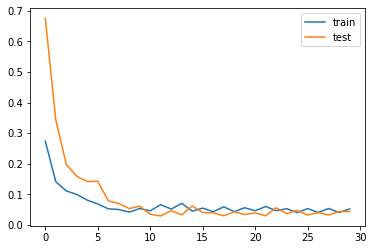

In [144]:
model = Sequential()
model.add(LSTM(300, input_shape=(input_1.shape[1], input_1.shape[2])))
model.add(Dropout(0.1))
# model.add(LSTM(25, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(2, activation="relu"))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(input_1, output_1, epochs=30, batch_size=8, validation_data=(input_2, output_2), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [145]:
# make prediction

yhat = model.predict(input_2)
input_2 = input_2.reshape((input_2.shape[0], input_2.shape[2]))
# # invert scaling for forecast
inv_yhat = concatenate((yhat, input_2[:, 2:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
# inv_yhat = inv_yhat[:,2]
# # invert scaling for actual
output_2 = output_2.reshape((len(output_2), 2))
inv_y = concatenate((output_2, input_2[:, 2:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
# inv_y = inv_y[:,0]
# # calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.277


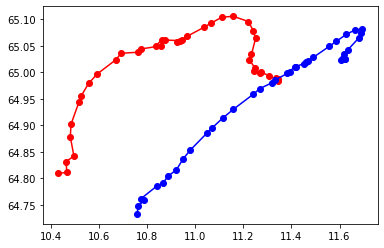

In [146]:
plt.plot(inv_y[:,0], inv_y[:,1], "r-o")
plt.plot(inv_yhat[:,0], inv_yhat[:,1], 'b-o')

In [147]:

# print(inv_yhat)

real_lon = []
real_lat = []

pred_lon = []
pred_lat = []

for i in range(inv_y.shape[0]):
  real_lon.append(inv_y[i][0])
  real_lat.append(inv_y[i][1])
  
  pred_lon.append(inv_yhat[i][0])
  pred_lat.append(inv_yhat[i][1])

print(len(real_lat))

39


In [72]:
# data

In [148]:
test_data = data.copy()
test_data = test_data[n_train_days:-2*NUM_TIME_STEPS_FORECASTS]
test_data.shape

(39, 6)

In [150]:
pred_data = test_data.copy()
# pred_data

In [151]:
pred_data['drifter_index'] = 123
pred_data['longitude'] = pred_lon
pred_data['latitude'] = pred_lat

# pred_data

In [153]:
plot_data = pd.concat([test_data, pred_data])
plot_data

,L,drifter_index,time,longitude,latitude,sea_surface_temperature
154,154,46320.0,2007-08-02 06:00:00,10.447000,64.725000,285.858
155,155,46320.0,2007-08-02 12:00:00,10.404000,64.756000,286.291
156,156,46320.0,2007-08-02 18:00:00,10.414000,64.773000,286.123
157,157,46320.0,2007-08-03 00:00:00,10.373000,64.784000,286.028
158,158,46320.0,2007-08-03 06:00:00,10.430000,64.809000,285.917
...,...,...,...,...,...,...
188,188,123.0,2007-08-10 18:00:00,11.617469,65.034799,286.732
189,189,123.0,2007-08-11 00:00:00,11.615720,65.027910,286.711
190,190,123.0,2007-08-11 06:00:00,11.607242,65.023141,286.791
191,191,123.0,2007-08-11 12:00:00,11.620901,65.024605,287.075


## For Ploting

In [154]:
import numpy as np                   # for multi-dimensional containers 
import pandas as pd                  # for DataFrames
import plotly.graph_objects as go    # for data visualisation
import plotly.express as px

path_to_key = '/content/drive/My Drive/Projects/MapBox/mapboxkey.txt'

with open(path_to_key) as f:
    contents = f.readlines()

access_token = contents[0]
px.set_mapbox_access_token(access_token)

In [155]:
plot_data['size'] = 1

In [156]:
fig = px.scatter_mapbox(
    plot_data, lat="latitude", lon="longitude",
    size="size", size_max=5,
    color="drifter_index", color_continuous_scale=px.colors.sequential.Pinkyl,
    hover_name="longitude",           
    mapbox_style='dark', zoom=5
)

fig.layout.coloraxis.showscale = False

fig.show()

## Animation

In [157]:
fig = px.scatter_mapbox(
    plot_data, lat="latitude", lon="longitude",
    size="size", size_max=5,
    color="drifter_index", color_continuous_scale=px.colors.sequential.Pinkyl,
    hover_name="time",           
    mapbox_style='dark', zoom=5,
    animation_frame="time", animation_group="longitude"
)

fig.show()

In [158]:
#speed adjustments
fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 200
fig.layout.updatemenus[0].buttons[0].args[1]["transition"]["duration"] = 1
fig.layout.coloraxis.showscale = False
fig.layout.sliders[0].pad.t = 10
fig.layout.updatemenus[0].pad.t= 10

fig.show()